In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, MaxPooling1D, Conv1D, Input, Dense, Dropout, GlobalAveragePooling1D, Embedding, Layer, MultiHeadAttention, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


2023-02-21 16:29:27.773549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

2023-02-21 16:29:30.495661: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-21 16:29:30.496964: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-21 16:29:30.578749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-21 16:29:30.578785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-21 16:29:30.581816: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-21 16:29:30.581862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.4.1
Keras version: 2.4.0
Using Tesla V100-SXM2-32GB


2023-02-21 16:29:31.225284: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [4]:
NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TITLE_LEN = 32 # maximum and minimum number of words
NUM_CLASSES = 2


labeled_content = pd.read_csv('data/labeled_headlines.csv')
labeled_content = labeled_content[labeled_content['score'] != 0]

#concatenate title and first 256 words in content in one column
# labeled_content['title_content'] = labeled_content['title'].astype(str) + ' ' + labeled_content['content'].astype(str).str[:256]


X = labeled_content['title'].astype(str).values
y = labeled_content['score'].values
                                #.astype('float32')

tokenizer = Tokenizer(
                    num_words=NUM_TOP_WORDS,
                    filters = '—!"“”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t…\'‘’'
                     )

tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))

X = pad_sequences(sequences, maxlen=MAX_TITLE_LEN)
y = np.where(y == -1, 0, 1)

# y = keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

print(f"Found {len(word_index):,} unique tokens. Distilled to {top_words:,} top words.")

Found 12,013 unique tokens. Distilled to 12,013 top words.


In [5]:
# now fill in the matrix, using the ordering from the
# keras word tokenizer from before
def generate_embed_matrix(embed):
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

    for word, i in word_index.items():

        try:
            embedding_vector = embed.loc[word]
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1
        except:
            #print(word)
            pass

    print(f"Embedding Shape: {embedding_matrix.shape}")
    print(f"Total words found: {found_words:,}")
    print(f"Percentage: {round(100 * found_words / embedding_matrix.shape[0], 2)}")
    
    return embedding_matrix

In [6]:
def generate_model(embed_matrix):   
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBED_SIZE,
                                weights=[embed_matrix],# here is the embedding getting saved
                                input_length=MAX_TITLE_LEN,
                                trainable=False)

    inputs = Input(shape=(MAX_TITLE_LEN,), dtype=tf.int32)
    embedding = embedding_layer(inputs)

    # Add a 1D Convolutional layer
    x = Conv1D(filters=128, kernel_size=5, activation='relu',
                                          kernel_initializer='he_uniform')(embedding)
    x = MaxPooling1D(pool_size=2)(x) # Add a Max Pooling layer

    # x = Dropout(0.20)(x)
    # x = Conv1D(128, 3, activation='relu',
    #            kernel_initializer='he_uniform')(x)

    # # new size is 195
    # x = MaxPooling1D(2)(x) # after max pool, size is 195/5 = 39
    # x = Dropout(0.25)(x)
    # x = Conv1D(128, 3, activation='relu',
    #            kernel_initializer='he_uniform')(x)

    #x = MaxPooling1D(2)(x) # this is the size to globally flatten 

    # Flatten the output of\ the Max Pooling layer
    x = Flatten()(x)
    x = Dropout(0.10)(x)
    x = Dense(units=64, activation='sigmoid')(x)
    x = Dense(units=32, activation='sigmoid')(x)

    # Add a Dense output layer with a single neuron and a sigmoid activation function
    outputs = Dense(units=1, activation='linear')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [7]:
%%time
numberbatch_embeddings = load_embeddings("embeddings/numberbatch-en-17.04b.txt")
numberbatch_embeddings.shape

EMBED_SIZE = numberbatch_embeddings.shape[1]

CPU times: user 27.5 s, sys: 851 ms, total: 28.4 s
Wall time: 28.5 s


In [8]:
numberbatch_embed_matrix = generate_embed_matrix(numberbatch_embeddings)
numberbatch_model = generate_model(numberbatch_embed_matrix)
numberbatch_model.summary()

Embedding Shape: (12014, 300)
Total words found: 11,346
Percentage: 94.44


2023-02-21 16:30:00.606916: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-21 16:30:00.609054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-21 16:30:00.609118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-21 16:30:00.609154: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-21 16:30:00.609171: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-21 16:30:00.609185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 32, 300)           3604200   
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 128)           192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                114752

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=402)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6958, 32)
X_test shape: (1740, 32)
y_train shape: (6958,)
y_test shape: (1740,)


In [10]:
numberbatch_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2048, epochs=35)

Epoch 1/35


2023-02-21 16:30:01.052099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-21 16:30:01.052842: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-02-21 16:30:01.406495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-21 16:30:01.661622: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-02-21 16:30:02.881401: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-02-21 16:30:02.938980: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


4/4 [==============================] - 5s 693ms/step - loss: 0.3704 - accuracy: 0.4953 - val_loss: 0.2544 - val_accuracy: 0.4236
Epoch 2/35
4/4 [==============================] - 0s 45ms/step - loss: 0.2573 - accuracy: 0.4661 - val_loss: 0.2538 - val_accuracy: 0.5000
Epoch 3/35
4/4 [==============================] - 0s 43ms/step - loss: 0.2469 - accuracy: 0.5003 - val_loss: 0.2260 - val_accuracy: 0.5885
Epoch 4/35
4/4 [==============================] - 0s 43ms/step - loss: 0.2226 - accuracy: 0.6991 - val_loss: 0.2170 - val_accuracy: 0.7983
Epoch 5/35
4/4 [==============================] - 0s 43ms/step - loss: 0.2137 - accuracy: 0.7782 - val_loss: 0.2008 - val_accuracy: 0.8132
Epoch 6/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1947 - accuracy: 0.8117 - val_loss: 0.1741 - val_accuracy: 0.8299
Epoch 7/35
4/4 [==============================] - 0s 44ms/step - loss: 0.1678 - accuracy: 0.8249 - val_loss: 0.1506 - val_accuracy: 0.8195
Epoch 8/35
4/4 [=====================

In [11]:
def plot_history(history, name="Results"):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))
 
    plt.subplot(1,2,1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')
 
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')
 
    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)
 
    plt.show()

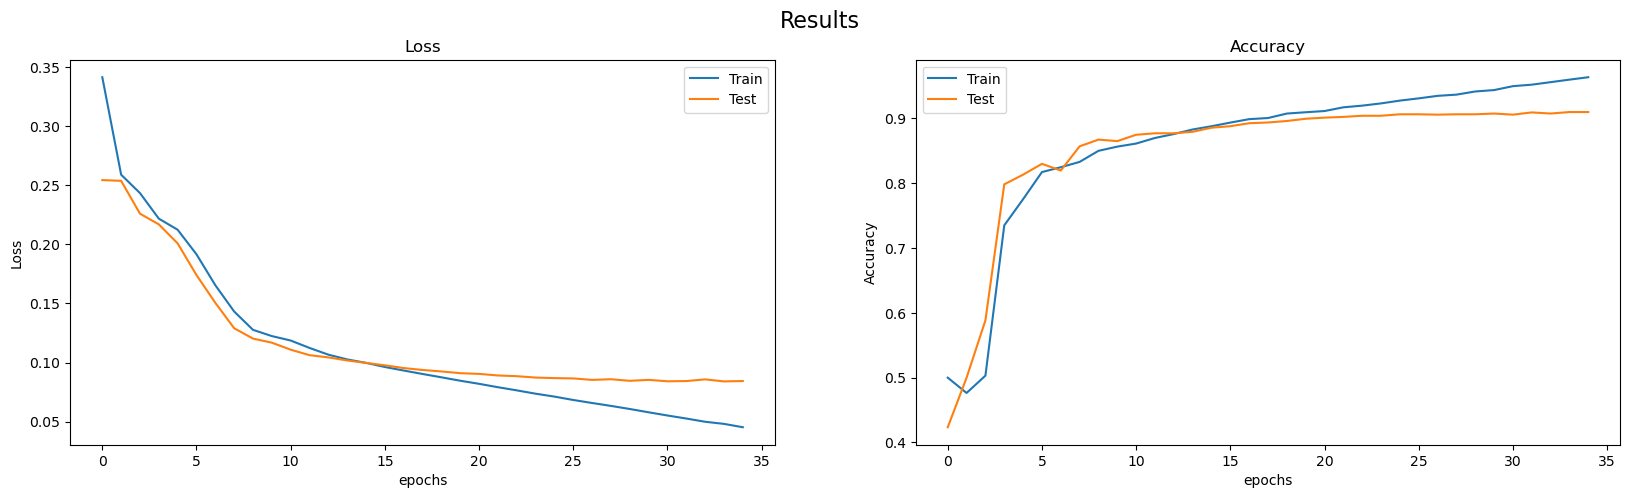

In [12]:
plot_history(numberbatch_model.history.history)

In [13]:
%%time
glove_embeddings = load_embeddings("embeddings/glove.840B.300d.txt")
glove_embeddings.shape

EMBED_SIZE = glove_embeddings.shape[1]

KeyboardInterrupt: 

In [21]:
#glove_embed_matrix = generate_embed_matrix(glove_embeddings)
# define the file name for the pickle file

pickle_file = "embeddings/glove_matrix.pickle"
# # open the file for writing in binary mode
# with open(pickle_file, 'wb') as f:
#     # pickle the embedding matrix
#     pickle.dump(embedding_matrix, f)
#     # print a message to confirm the pickling
#     print(f"Embedding matrix pickled to {pickle_file}")

In [22]:
# open the pickle file for reading in binary mode
with open(pickle_file, 'rb') as f:
    # load the pickled embedding matrix
    glove_embed_matrix = pickle.load(f)
    # print a message to confirm the loading
    print(f"Embedding matrix loaded from {pickle_file}")

Embedding matrix loaded from embeddings/glove_matrix.pickle


Epoch 1/35
4/4 [==============================] - 1s 80ms/step - loss: 0.2423 - accuracy: 0.5199 - val_loss: 0.1968 - val_accuracy: 0.6977
Epoch 2/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1832 - accuracy: 0.7309 - val_loss: 0.1608 - val_accuracy: 0.7603
Epoch 3/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1526 - accuracy: 0.7778 - val_loss: 0.1375 - val_accuracy: 0.8132
Epoch 4/35
4/4 [==============================] - 0s 55ms/step - loss: 0.1307 - accuracy: 0.8374 - val_loss: 0.1200 - val_accuracy: 0.8494
Epoch 5/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1167 - accuracy: 0.8634 - val_loss: 0.1109 - val_accuracy: 0.8684
Epoch 6/35
4/4 [==============================] - 0s 45ms/step - loss: 0.1074 - accuracy: 0.8774 - val_loss: 0.1068 - val_accuracy: 0.8759
Epoch 7/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1004 - accuracy: 0.8888 - val_loss: 0.0987 - val_accuracy: 0.8879
Epoch 8/35
4/4 [===========

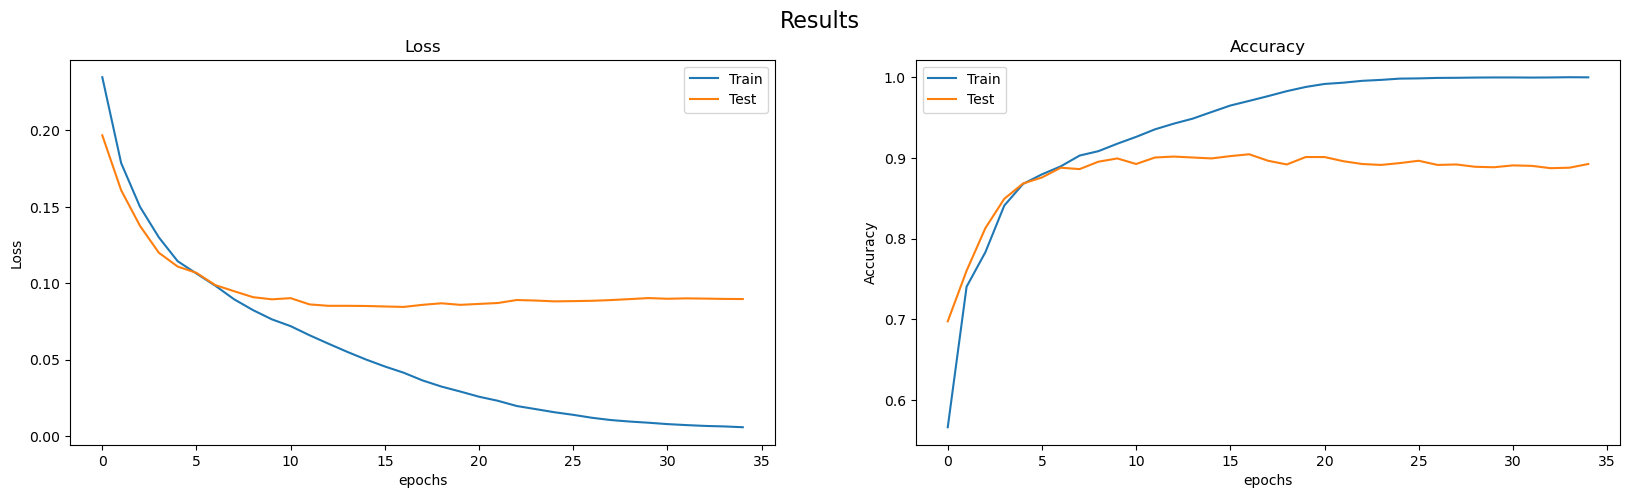

In [23]:
glove_model = generate_model(glove_embed_matrix)
glove_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2048, epochs=35)
plot_history(glove_model.history.history)

In [24]:
labeled_test = pd.read_csv('data/labeled_headlines.csv')
labeled_test = labeled_test[labeled_test['score'] == 0]

test = labeled_test['title'].astype(str).values

seq = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(seq, maxlen=MAX_TITLE_LEN)

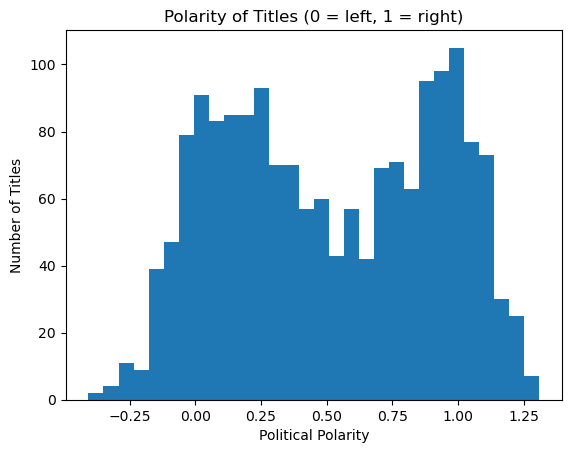

In [31]:
glove_test_distribution = glove_model.predict(X_test)

plt.hist(glove_test_distribution,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

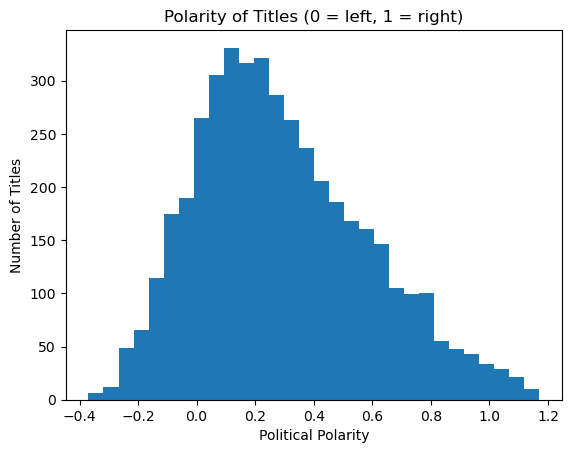

In [32]:
glove_neutral_dist = glove_model.predict(test_padded)
plt.hist(glove_neutral_dist,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

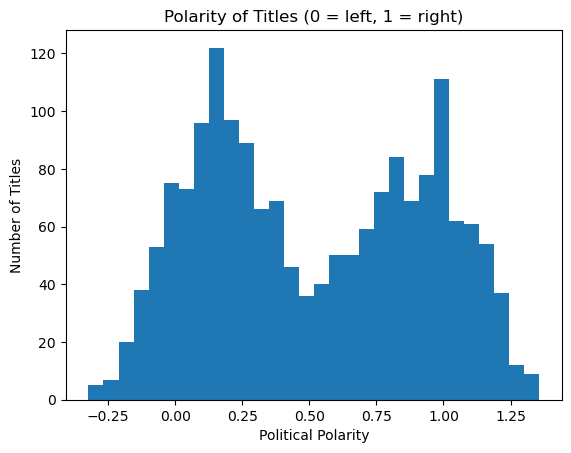

In [33]:
numberbatch_test_distribution = numberbatch_model.predict(X_test)

plt.hist(numberbatch_test_distribution,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

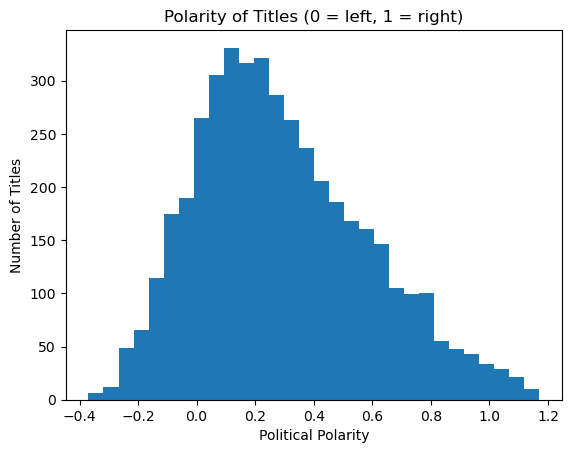

In [34]:
numberbatch_neutral_dist = glove_model.predict(test_padded)
plt.hist(numberbatch_neutral_dist,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

In [35]:
print("Numberbatch mean: " + str(numberbatch_neutral_dist.mean()))
print("Glove mean: " + str(glove_neutral_dist.mean()))

Numberbatch mean: 0.2932625
Glove mean: 0.2932625
